In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

In [36]:
N = 10
J = 50
span = np.linspace(0, 1, N)
image = (np.sin(2*np.pi*span)+1)/2

class AdaptiveWeights(object):
    def __init__(self, w, learning_rate):
        self.w = w
        self.learning_rate = learning_rate
        
    def make_node(self):
        def update_forward(t, x, self=self):
            pre_value = x
            post_value = np.dot(self.w, x)
            self.w += self.learning_rate * np.outer(post_value, pre_value)
            return post_value
        return nengo.Node(update_forward, size_in=self.w.shape[1], size_out=self.w.shape[0])
    
        


model = nengo.Network()
with model:
    stim = nengo.Node(image)
    
    residual = nengo.Node(None, size_in=N)
    
    v1 = nengo.Ensemble(n_neurons=J, dimensions=1,
                          neuron_type=nengo.RectifiedLinear(),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    
    nengo.Connection(v1.neurons, v1.neurons, synapse=0)
    
    learning_rate=1e-6
    tau = 0
    w = np.random.uniform(-0.02, 0.02, (J, N))
    adapt_fwd = AdaptiveWeights(w, learning_rate=learning_rate)
    fwd_node = adapt_fwd.make_node()
    adapt_rev = AdaptiveWeights(w.T, learning_rate=learning_rate)
    rev_node = adapt_rev.make_node()
    
    
    #nengo.Connection(residual, v1.neurons, transform=w, synapse=tau)
    nengo.Connection(residual, fwd_node, synapse=tau)
    nengo.Connection(fwd_node, v1.neurons, synapse=None)
        
    nengo.Connection(stim, residual, synapse=0)
    #nengo.Connection(v1.neurons, residual, transform=-w.T, synapse=tau)
    nengo.Connection(v1.neurons, rev_node, synapse=tau)
    nengo.Connection(rev_node, residual, transform=-1, synapse=None)
    
    p_v1 = nengo.Probe(v1.neurons)
    p_res = nengo.Probe(residual)
    
    
sim = nengo.Simulator(model)
sim.run(3.0)
                        

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

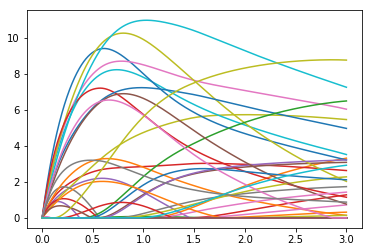

In [37]:
plt.plot(sim.trange(), sim.data[p_v1])
plt.show()

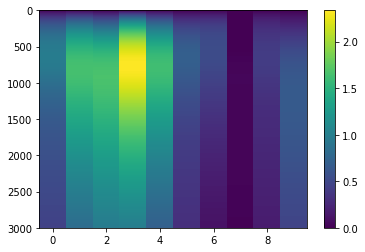

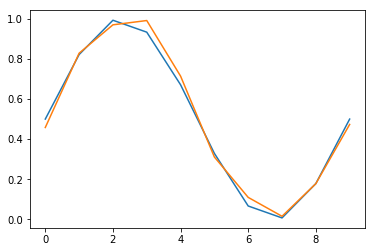

In [38]:
recon = np.dot(sim.data[p_v1], w)
plt.imshow(recon, aspect='auto')
plt.colorbar()
plt.figure()
plt.plot(image)
plt.plot(recon[-1])

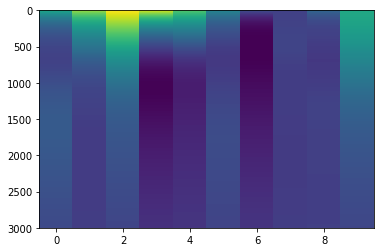

In [39]:
plt.imshow(sim.data[p_res][:,:], aspect='auto')